# TalkingData AdTracking Fraud Detection Challenge

### Description

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest
mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Evaluation
Submissions are evaluated on <b>area under the ROC curve </b> between the predicted probability and the observed target.

### Data fields
Each row of the training data contains a click record, with the following features.

<b>ip:</b> ip address of click.<br>
<b>app:</b> app id for marketing.<br>
<b>device:</b> device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)<br>
<b>os:</b> os version id of user mobile phone<br>
<b>channel:</b> channel id of mobile ad publisher<br>
<b>click_time:</b> timestamp of click (UTC)<br>
<b>attributed_time:</b> if user download the app for after clicking an ad, this is the time of the app download<br>
<b>is_attributed:</b> the target that is to be predicted, indicating the app was downloaded<br>

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

<b>click_id:</b> reference for making predictions<br>
<b>is_attributed:</b> not included

## Import Packages

In [1]:
import pandas as pd
import time
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
np.random.seed(42)

## Import Data

In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('loading train data...')

chunk = 40000000
#chunk = 87000000
start = 144903891
#start = 184903891-chunk

train_df = pd.read_csv('data/train.csv',  skiprows=range(1, start),  nrows=chunk, dtype=dtypes, 
                       usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

print('loading test data...')
test_df = pd.read_csv('data/test.csv', dtype=dtypes, 
                      usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

len_train = len(train_df)

# Join the datasets to apply the transformations only one time
train_df=train_df.append(test_df)

train_df.shape, test_df.shape

loading train data...
loading test data...


C:\Users\Windows10\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


((58790469, 8), (18790469, 7))

In [4]:
print('Train Data:')
display(train_df.head())

print('Test Data:')
display(test_df.head())

Train Data:


,app,channel,click_id,click_time,device,ip,is_attributed,os
0,15,111,NaN,2017-11-09 04:03:08,1,33924,0.0,19
1,3,280,NaN,2017-11-09 04:03:08,1,37383,0.0,13
2,15,245,NaN,2017-11-09 04:03:08,1,122294,0.0,10
3,9,145,NaN,2017-11-09 04:03:08,1,73258,0.0,25
4,15,430,NaN,2017-11-09 04:03:08,1,73347,0.0,13


Test Data:


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [5]:
del test_df
gc.collect()

20

# EDA

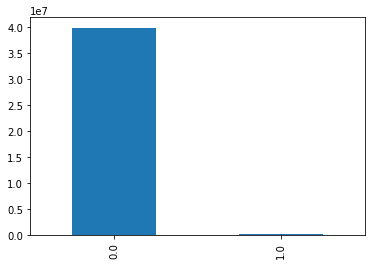

In [6]:
train_df['is_attributed'].value_counts().plot(kind='bar');

## Feature Engineering

In [7]:
# extracting hour and day features

train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

gc.collect()

2660

In [8]:
# grouping by ip-day-hour combination

gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_tcount'})

train_df = train_df.merge(gp, on=['ip','day','hour'], how='left')

del gp
gc.collect()

0

In [9]:
# grouping by ip-app combination 

gp = train_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})

train_df = train_df.merge(gp, on=['ip','app'], how='left')

del gp
gc.collect()

20

In [10]:
# grouping by ip-app-os combination

gp = train_df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})

train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')

del gp
gc.collect()

20

In [11]:
# Adding features with var and mean hour

# grouping by: ip day channel -> var hour

gp = train_df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_tchan_count'})

train_df = train_df.merge(gp, on=['ip','day','channel'], how='left')

del gp
gc.collect()

20

In [12]:
# grouping by: ip_app_os_var_hour

gp = train_df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var'})

train_df = train_df.merge(gp, on=['ip','app', 'os'], how='left')

del gp
gc.collect()

20

In [13]:
# grouping by : ip_app_channel_var_day

gp = train_df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})

train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')

del gp
gc.collect()

20

In [14]:
# grouping by : ip_app_chl_mean_hour

gp = train_df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})

train_df = train_df.merge(gp, on=['ip','app', 'channel'], how='left')

del gp
gc.collect()

20

In [15]:
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58790469 entries, 0 to 58790468
Data columns (total 17 columns):
app                         uint16
channel                     uint16
click_id                    float64
click_time                  object
device                      uint16
ip                          uint32
is_attributed               float64
os                          uint16
hour                        uint8
day                         uint8
ip_tcount                   uint16
ip_app_count                uint16
ip_app_os_count             uint16
ip_tchan_count              float64
ip_app_os_var               float64
ip_app_channel_var_day      float64
ip_app_channel_mean_hour    float64
dtypes: float64(6), object(1), uint16(7), uint32(1), uint8(2)
memory usage: 4.6+ GB


## Separate the Datasets

In [16]:
len_train

40000000

In [17]:
test_df = train_df[len_train:]
val_df = train_df[(len_train-2500000):len_train]
train_df = train_df[:(len_train-2500000)]

train_df.shape, test_df.shape, val_df.shape

((37500000, 17), (18790469, 17), (2500000, 17))

In [18]:
train_df.head()

,app,channel,click_id,click_time,device,ip,is_attributed,os,hour,day,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour
0,15,111,NaN,2017-11-09 04:03:08,1,33924,0.0,19,4,9,221,224,58,19.000000,16.458863,0.300000,9.166667
1,3,280,NaN,2017-11-09 04:03:08,1,37383,0.0,13,4,9,250,298,77,1.061930,13.997266,0.000000,5.215686
2,15,245,NaN,2017-11-09 04:03:08,1,122294,0.0,10,4,9,179,41,6,0.214286,0.000000,0.000000,4.250000
3,9,145,NaN,2017-11-09 04:03:08,1,73258,0.0,25,4,9,56,166,2,3.136782,0.000000,NaN,4.000000
4,15,430,NaN,2017-11-09 04:03:08,1,73347,0.0,13,4,9,42,64,12,14.250000,17.901515,0.266667,8.166667


## Modeling

In [19]:
# function
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                       feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)
    
    print("preparing validation datasets")
    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    evals_results = {}
    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)
    n_estimators = bst1.best_iteration
    
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])
    
    print('\nPlot - Feature Importance')
    lgb.plot_importance(bst1)
    plt.show()
    
    return bst1

In [20]:
# defininf the features and target

target = 'is_attributed'

predictors = ['app','device','os', 'channel', 'hour', 'day', 
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour']



categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']

sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype('int')
gc.collect()

20

Training...
preparing validation datasets


C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 30 rounds
[10]	train's auc: 0.922336	valid's auc: 0.958311
[20]	train's auc: 0.954901	valid's auc: 0.969784
[30]	train's auc: 0.95715	valid's auc: 0.969947
[40]	train's auc: 0.959156	valid's auc: 0.97194
[50]	train's auc: 0.960166	valid's auc: 0.972843
[60]	train's auc: 0.961038	valid's auc: 0.974921
[70]	train's auc: 0.961247	valid's auc: 0.974789
[80]	train's auc: 0.961097	valid's auc: 0.975296
[90]	train's auc: 0.957243	valid's auc: 0.971817
[100]	train's auc: 0.903312	valid's auc: 0.912131
Early stopping, best iteration is:
[76]	train's auc: 0.961589	valid's auc: 0.975459

Model Report
n_estimators :  76
auc: 0.9754587044742462

Plot - Feature Importance


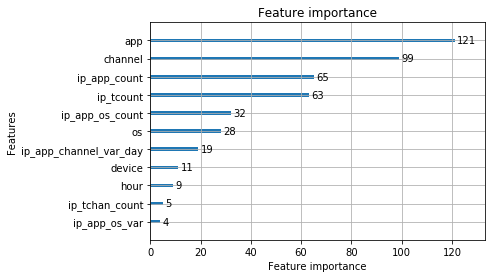

[536.0170044898987]: model training time
Predicting...
writing to file...
done...


In [21]:
print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.15,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99.7, # because training data is extremely unbalanced 
    'reg_alpha': .3
}
bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=2500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))

# del train_df
# del val_df
# gc.collect()

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors])

print("writing to file...")
sub.to_csv('02-sub_lgb_balanced99.csv',index=False)

print("done...")

## Evaluate Model

In [22]:
print("Predicting in validation dataset...")

predictions_lgbm_valdf_prob = bst.predict(val_df[predictors])

predictions_lgbm_valdf = np.where(predictions_lgbm_valdf_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

Predicting in validation dataset...


In [23]:
#Print accuracy
acc_lgbm = accuracy_score(val_df['is_attributed'], predictions_lgbm_valdf)
print('Overall accuracy of Light GBM model:', acc_lgbm)

Overall accuracy of Light GBM model: 0.986868


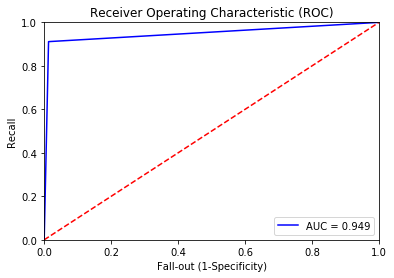

AUC score: 0.9491764798438084


In [24]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(val_df['is_attributed'], predictions_lgbm_valdf)

roc_auc = auc(false_positive_rate, recall)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

<Figure size 432x288 with 0 Axes>

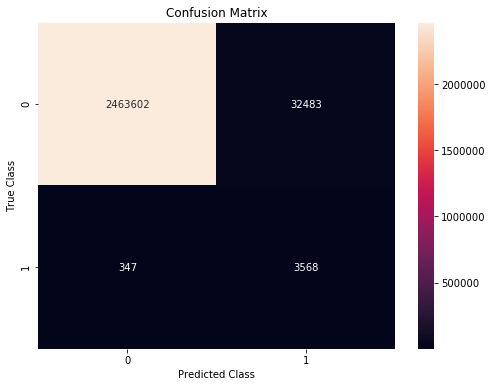

In [25]:
#Print Confusion Matrix

plt.figure()
cm = confusion_matrix(val_df['is_attributed'], predictions_lgbm_valdf)

labels = ['App Not Downloaded', 'App Downloaded']
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt='d',vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [26]:
# classification report

report = classification_report(val_df['is_attributed'], predictions_lgbm_valdf)

print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   2496085
         1.0       0.10      0.91      0.18      3915

    accuracy                           0.99   2500000
   macro avg       0.55      0.95      0.59   2500000
weighted avg       1.00      0.99      0.99   2500000



In [27]:
gc.collect()

10074